# Reinforcement learning in a Grid World

The following classes implement a "puddle world" and a Q learner for it. 

Read through them, and consider what effects the parameters may have. 

Construct puddle worlds of different sizes (I'd suggest a max size of 100x100 as on larger grids it will take a longer time to find the target initially. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random

In [3]:
class SimpleGrid:
    
    def __init__( self, rows, cols, targetr, targetc, targetsize, statepenalty, puddler, puddlec, puddleh, puddlew, puddlepenalty ):
        self.rows = rows
        self.cols = cols # numbers of rows and cols in the grid world
        self.targetr = targetr
        self.targetc = targetc  # row and column of centre of target; 
        self.targetsize = targetsize #  target is all gridpoints within a distance targetsize of target centre in horizontal and vertical directions
        
        self.statepenalty = statepenalty # punishment for each timestep
        self.puddler = puddler
        self.puddlec = puddlec # centre of puddle 
        self.puddleh = puddleh
        self.puddlew = puddlew  # puddle row, column, height, and width 
        self.puddlepenalty = puddlepenalty # punishment each time current state is in the puddle
        
    def atgoal( self, state ): # returns true if (r,c) is in the goal and false if not
        (r,c) = state
        if (abs( r - self.targetr ) < self.targetsize) and (abs( c - self.targetc) < self.targetsize):
            return True
        else:
            return False

    def inpuddle( self, state ): # returns true if current state is in puddle
        (r,c) = state
        if (abs( r - self.puddler ) < self.puddleh) and (abs( c - self.puddlec) < self.puddlew):
            return True
        else:
            return False
    
    def ingrid( self, state ): # returns True iff r, c is within grid
        (r,c) = state
        return ( r >= 0 ) and (r < self.rows) and (c >= 0) and (c < self.cols)
    
    def randomstart( self, r, c, h, w ): # random start from a specified rectangle
        return ( np.random.randint(r-h, r+h ), np.random.randint( c-w, c+w ))
    
    def nextstatereward( self, state, action ):
        (r,c) = state
        if action == 0: # move (1,0)
            newr = min( self.rows-1, r+1 )
            newc = c
        elif action == 1: # move (0,1)
            newr = r
            newc = min( self.cols-1, c+1 )
        elif action == 2: # move (-1, 0)
            newr = max( 0, r-1 )
            newc = c 
        elif action == 3: # move (0,-1)
            newr = r
            newc = max( 0, c-1 )
        else:
            raise ValueError('bad action')
        newstate = (newr, newc)
        if self.atgoal( newstate ):
            endofepoch = True
            reward = 1.0 
        else:
            endofepoch = False
            if self.inpuddle( newstate ):
                reward = self.puddlepenalty
            else:
                reward = self.statepenalty
        return ( state, action, newstate, reward, endofepoch )
    
    
        

In [4]:
class QLearner: 
    
    def __init__( self, grid, gamma ):
        self.grid = grid # a SimpleGrid defined above
        self.Q = np.zeros([grid.rows, grid.cols, 4])
        self.SAcounts = np.zeros( [grid.rows, grid.cols, 4] )
        self.actions = np.array([0,1,2,3]) # we will use this repeatedly so create it only once
        self.gamma = gamma
       
    def setqvalues( self, val ):
        self.Q[:,:,:] = val
    
    def zerovisitcounts( self ):
        self.SAcounts[:,:,:] = 0 
        
    def qlearnupdate( self, episode, alpha=1.0 ):
        (s,a,sprime,reward, endofepoch) = episode
        (r,c) = s
        (rprime, cprime) = sprime
        if endofepoch: # do not take value of next state into account
            self.Q[r,c,a] = (1 - alpha) * self.Q[r,c,a] + alpha * reward
        else: 
            vprime = np.max( self.Q[ rprime, cprime, : ] ) # max Q value of next state
            self.Q[r,c,a] = (1 - alpha) * self.Q[r,c,a] + alpha * (reward + self.gamma * vprime ) 
            self.SAcounts[r,c,a] += 1
             
    def valueiteration( self, n=1 ):
        for timestep in range(n):
            for r in range(self.grid.rows):
                for c in range(self.grid.cols):
                    for a in range(4):
                        sasr = self.grid.nextstatereward( (r,c), a )
                        self.qlearnupdate( sasr )
    
    def epsilongreedy( self, state, epsilon ): # returns an action 
        if np.random.random() < epsilon: 
            return np.random.randint(0,4)
        else:
            (r,c) = state
            maxq = np.max( self.Q[r,c,:])
            maxqactions = self.actions[ self.Q[r,c,:] == maxq ]
            action_index = np.random.randint(0, maxqactions.size )
            return maxqactions[ action_index ]
    
    def values( self ):
        return self.Q.max(axis=2)
    
    def visitcounts( self ):
        return self.SAcounts.sum(axis=2)
    
    def trajectory( self, startstate, epsilon=0.1, alpha=1.0): # continues from start state until target is reached
        transitioncount = 0 
        s = startstate
        epochend = False
        while not(epochend):
            a = self.epsilongreedy(s, epsilon)
            sasr = self.grid.nextstatereward( s, a )
            transitioncount += 1
            self.qlearnupdate( sasr, alpha )
            epochend = sasr[4]
            s = sasr[2]
        return transitioncount
    
    def gettrajectory( self, startstate, epsilon=0.1, alpha=1.0 ):
        trajectory = np.zeros( self.grid.rows, self.grid.cols )
        transitioncount = 0 
        s = startstate
        epochend = False
        while not( epochend ):
            a = self.epsilongreedy( s, epsilon )
            sasr = self.grid.nextstatereward( s, a )
            transitioncount += 1 
            (r,c) = sasr[0]
            trajectory[r,c] = 1.0
            self.qlearnupdate( sasr, alpha )
            epochend = sasr[4]
            s = sasr[2]
        return trajectory
        
    def qlearnrun( self, ntrials, epsilon=0.1, alpha=1.0 ):
        runlengths = np.zeros([ntrials])
        for trialx in range(ntrials):
            startstate = ( np.random.randint(0,self.grid.rows), np.random.randint(0,self.grid.cols) )
            # this is a random state from the entire grid - you can change this
            runlengths[trialx] = self.trajectory( startstate, epsilon, alpha )
        return runlengths
                

In [5]:
grid1 = SimpleGrid( 100,100,80,50,10,-0.2, 40,50,10,40,-2.0)

In [6]:
qlearner1 = QLearner( grid1, 0.99)

In [7]:
qlearner1.valueiteration(200)

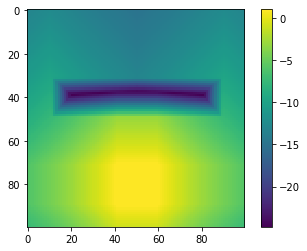

In [8]:
plt.imshow( qlearner1.values() )
plt.colorbar()

In [9]:
runlengths = qlearner1.qlearnrun( 1200 )

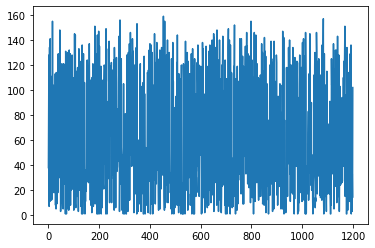

In [10]:
plt.plot( runlengths )

In [11]:
qlearner1.epsilongreedy( (4,4), 0.1)

1

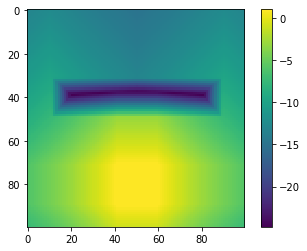

In [12]:
plt.imshow( qlearner1.values() )
plt.colorbar()

In [13]:
qlearner1.Q.max(axis=2)

array([[-13.11782209, -13.04830515, -12.97808601, ..., -12.90715758,
        -12.97808601, -13.04830515],
       [-13.04830515, -12.97808601, -12.90715758, ..., -12.83551271,
        -12.90715758, -12.97808601],
       [-12.97808601, -12.90715758, -12.83551271, ..., -12.76314415,
        -12.83551271, -12.90715758],
       ...,
       [ -7.03690704,  -6.90596671,  -6.77370374, ...,  -6.64010479,
         -6.77370374,  -6.90596671],
       [ -7.16653797,  -7.03690704,  -6.90596671, ...,  -6.77370374,
         -6.90596671,  -7.03690704],
       [ -7.29487259,  -7.16653797,  -7.03690704, ...,  -6.90596671,
         -7.03690704,  -7.16653797]])

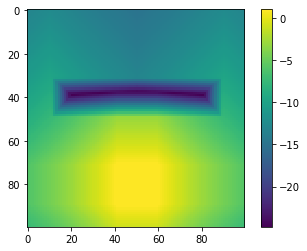

In [14]:
plt.imshow(qlearner1.Q.max(axis=2))
plt.colorbar()

## Things to do

1. Plot smoother curves of the trajectory lengths

2. Figure out optimal performance ( you can use the Q values calculated using value iteration to run the Q learner, and see how long the trajectories turn out to be...) 

3. Examine the visit counts: can you see the effect of "path habits in state space"? 

4  Examine the effect of initial q values that are too large and too small ( I suggest doing this initially on a smaller 10x10 or 20x20 grid. You may have to alter the code to enforce a maximum trajectory length, as the agent may get stuck in a corner of the grid when the initial Q values are very low.)

5. Examine the effectg of epsilon - on this problem, does the Q learner learn better with totally random behaviuour (ie set epsilon equal to 1 )? 

6. An interesting recent algorithm is so-called "Double Q Learning", introduced in https://papers.nips.cc/paper/3964-double-q-learning

Double Q learning is an ingenious idea to reduce a bias that is inherent in ordinary Q learning.  Compare the behaviour of double Q learning with ordinary Q learning on the puddle-world problem. (See the implementation of double Q learning below...) 



In [15]:
class DoubleQLearner: 
    
    def __init__( self, grid, gamma ):
        self.grid = grid # a SimpleGrid defined above
        self.Q = np.zeros([2,grid.rows, grid.cols, 4])
        self.SAcounts = np.zeros( [grid.rows, grid.cols, 4] )
        self.actions = np.array([0,1,2,3]) # we will use this repeatedly so create it only once
        self.gamma = gamma
       
    def setqvalues( self, val ):
        self.Q[:,:,:,:] = val
    
    def zerovisitcounts( self ):
        self.SAcounts[:,:,:] = 0 
        
    def qlearnupdate( self, episode, q, alpha=1.0 ):
        (s,a,sprime,reward, endofepoch) = episode
        (r,c) = s
        (rprime, cprime) = sprime
        if endofepoch: # do not take value of next state into account
            self.Q[q, r,c,a] = (1 - alpha) * self.Q[q, r,c,a] + alpha * reward
        else: 
            vprime = np.max( self.Q[1-q, rprime, cprime, : ] ) # This is the key line that implements double Q learning
            self.Q[q, r,c,a] = (1 - alpha) * self.Q[q, r,c,a] + alpha * (reward + self.gamma * vprime ) 
            self.SAcounts[r,c,a] += 1
             
    def valueiteration( self, n=1 ):
        for timestep in range(n):
            for r in range(self.grid.rows):
                for c in range(self.grid.cols):
                    for a in range(4):
                        sasr = self.grid.nextstatereward( (r,c), a )
                        self.qlearnupdate( sasr, 0 )
                        self.qlearnupdate( sasr, 1 )
    
    def epsilongreedy( self, state, q, epsilon ): # returns an action 
        if np.random.random() < epsilon: 
            return np.random.randint(0,4)
        else:
            (r,c) = state
            maxq = np.max( self.Q[q,r,c,:])
            maxqactions = self.actions[ self.Q[q,r,c,:] == maxq ]
            action_index = np.random.randint(0, maxqactions.size )
            return maxqactions[ action_index ]
    
    def values( self, q ):  # we need to specify which Q values are used in computing V 
        return self.Q[q,:,:,:].max(axis=2)
    
    def visitcounts( self ):
        return self.SAcounts.sum(axis=2)
    
    def trajectory( self, startstate, epsilon=0.1, alpha=1.0): # continues from start state until target is reached
        transitioncount = 0 
        s = startstate
        epochend = False
        while not(epochend):
            q = np.random.randint(0,2)
            a = self.epsilongreedy(s, q, epsilon)
            sasr = self.grid.nextstatereward( s, a )
            transitioncount += 1
            self.qlearnupdate( sasr, q, alpha )
            epochend = sasr[4]
            s = sasr[2]
        return transitioncount
    
    def gettrajectory( self, startstate, epsilon=0.1, alpha=1.0 ):
        trajectory = np.zeros( self.grid.rows, self.grid.cols )
        transitioncount = 0 
        s = startstate
        epochend = False
        while not( epochend ):
            q = np.random.randint(0,1)
            a = self.epsilongreedy( s, epsilon )
            sasr = self.grid.nextstatereward( s, a )
            transitioncount += 1 
            (r,c) = sasr[0]
            trajectory[r,c] = 1.0
            self.qlearnupdate( sasr, q, alpha )
            epochend = sasr[4]
            s = sasr[2]
        return trajectory
        
    def qlearnrun( self, ntrials, epsilon=0.1, alpha=1.0 ):
        runlengths = np.zeros([ntrials])
        for trialx in range(ntrials):
            startstate = ( np.random.randint(0,self.grid.rows), np.random.randint(0,self.grid.cols) )
            # this is a random state from the entire grid - you can change this
            runlengths[trialx] = self.trajectory( startstate, epsilon, alpha )
        return runlengths
                

In [16]:
doubleqlearner = DoubleQLearner( grid1, 0.99)

In [17]:
runlengths = doubleqlearner.qlearnrun( 1200 )

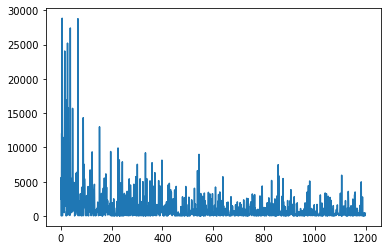

In [18]:
plt.plot( runlengths )

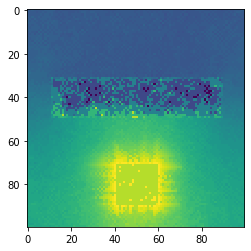

In [19]:
plt.imshow( doubleqlearner.values(0))

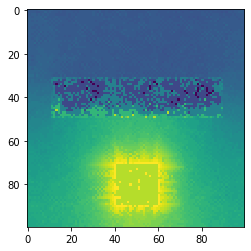

In [20]:
plt.imshow( doubleqlearner.values(1))

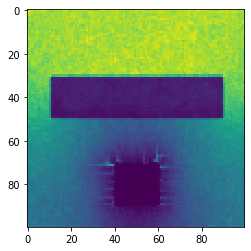

In [21]:
plt.imshow( doubleqlearner.visitcounts() )